# 1. 线性回归（简化模型）

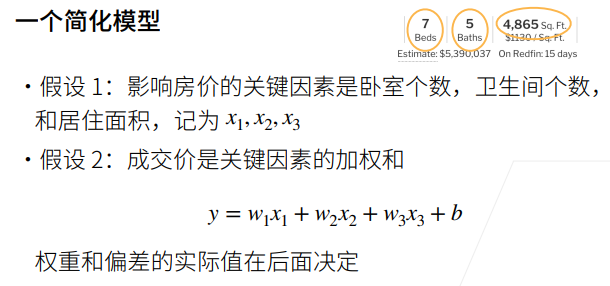

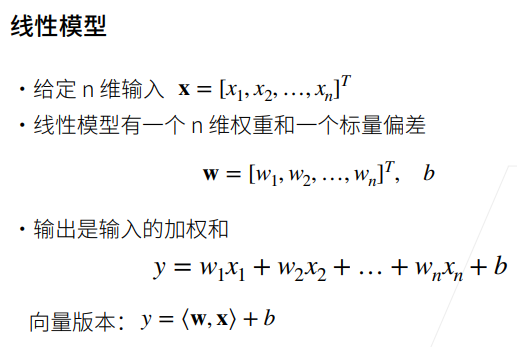

# 2. 神经网络

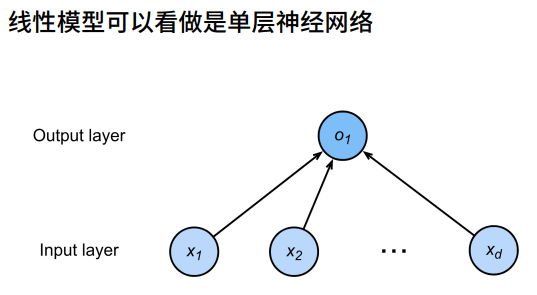

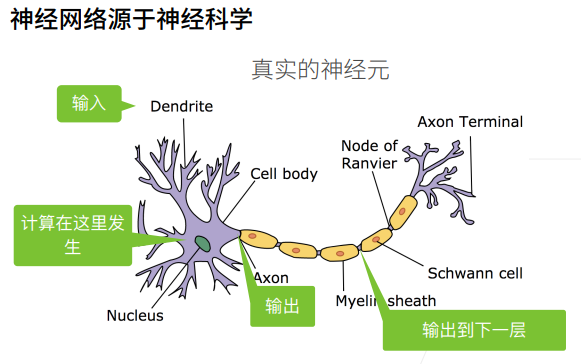

# 3. 线性回归（求最优解）

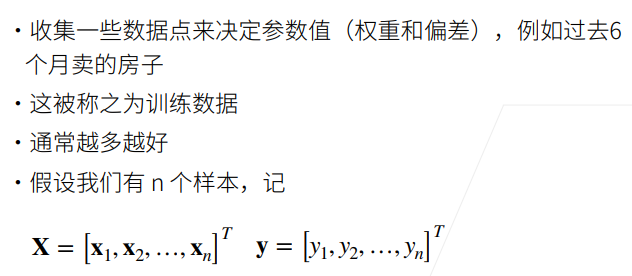

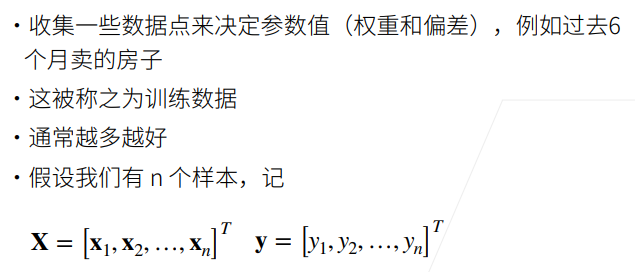

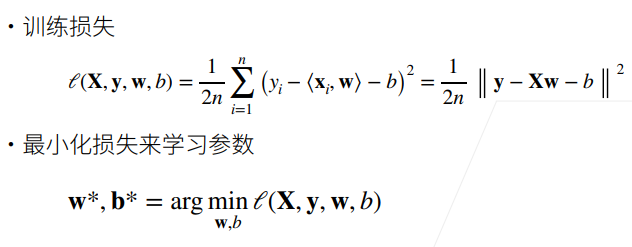

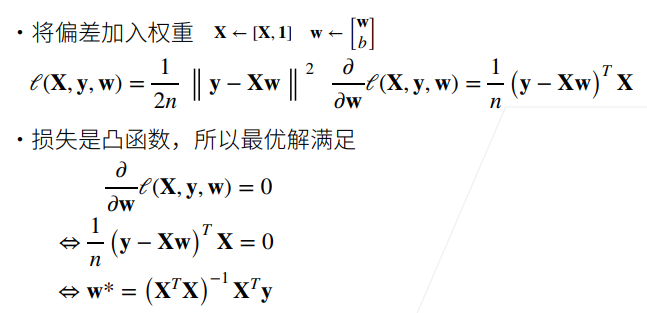

# 4. 线性回归（总结）

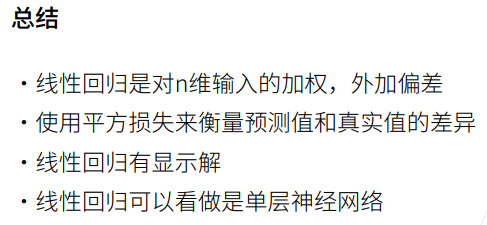

# 5. 优化方法

## 5.1 梯度下降法

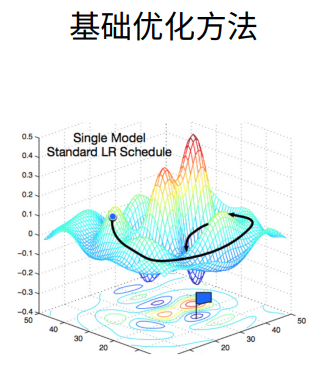

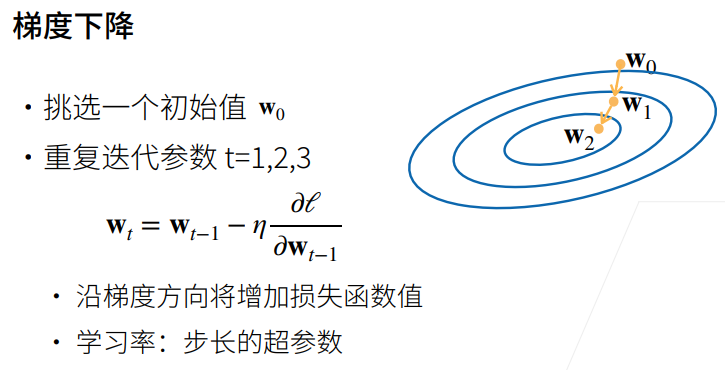

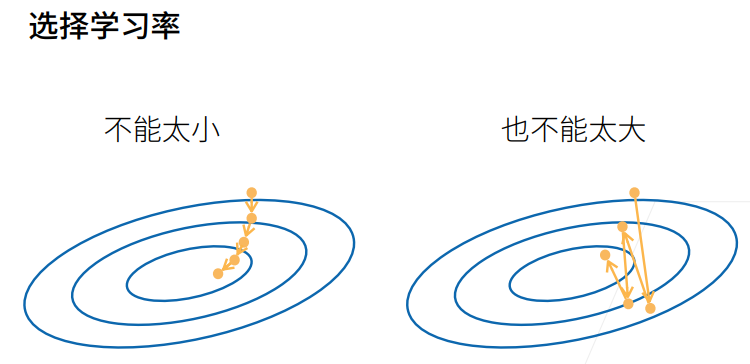

## 5.2 小批量随即梯度下降法

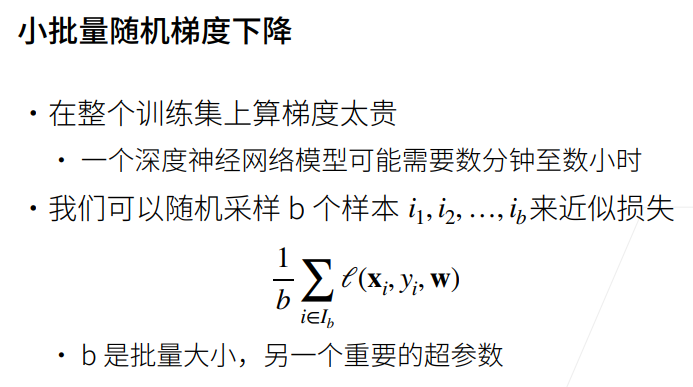

## 5.3 选择批量大小

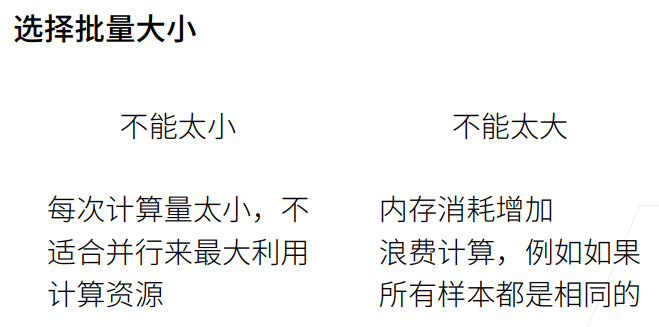

## 5.4 总结

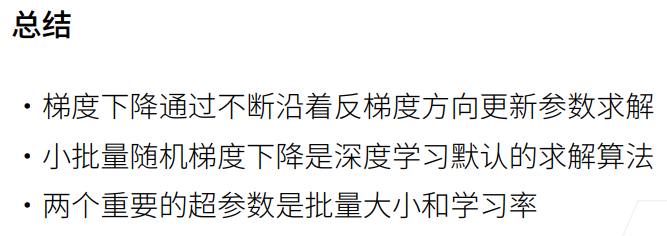

# 6. 线性回归（使用自定义）

① 将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随即梯度下降优化器。

## 6.1 生成数据集

① 根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项ϵ生成数据集及其标签：$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$。

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_exaples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_exaples,len(w)))
    print("X.shape:",X.shape)
    y = torch.matmul(X,w) + b
    print("y.shape:",y.shape)
    y += torch.normal(0,0.01,y.shape)
    print("y.shape:",y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print("features.shape:",features.shape)
print("labels.shape:",labels.shape)

X.shape: torch.Size([1000, 2])
y.shape: torch.Size([1000])
y.shape: torch.Size([1000])
features.shape: torch.Size([1000, 2])
labels.shape: torch.Size([1000, 1])


## 6.2 绘制数据集

① features中每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标签）。

features: tensor([-1.2519, -1.9356]) 
label: tensor([8.2824])


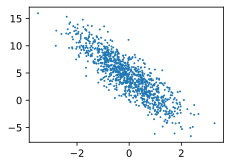

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_exaples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_exaples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0],'\nlabel:',labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)  # 只有detach后才能转到numpy里面去     

In [3]:
from d2l import torch as d2l
help(d2l.set_figsize)

Help on function set_figsize in module d2l.torch:

set_figsize(figsize=(3.5, 2.5))
    Set the figure size for matplotlib.



In [4]:
from d2l import torch as d2l
help(d2l.plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
    
        Note that *c* should not be a single nu

## 6.3 读取小批量

features: tensor([-0.3649,  0.1915]) 
label: tensor([2.8186])
tensor([[ 0.0121, -0.8915],
        [ 0.0873, -0.2825],
        [-1.2352,  0.0334],
        [-1.6237,  0.2243],
        [-1.0160,  0.4319],
        [ 0.0915,  0.1113],
        [-0.6346,  1.3844],
        [-1.4504, -0.0873],
        [-0.5357,  1.5457],
        [-0.5088,  0.0778]]) 
 tensor([[ 7.2667],
        [ 5.3237],
        [ 1.6068],
        [ 0.1980],
        [ 0.7058],
        [ 3.9992],
        [-1.7850],
        [ 1.6098],
        [-2.1443],
        [ 2.9316]])


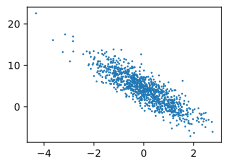

In [5]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_exaples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_exaples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0],'\nlabel:',labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)   

# data_iter函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size,features,labels):
    num_examples = len(features)  # 样本个数
    indices = list(range(num_examples)) # 样本索引
    # 这些样本是随即读取的，没有特定的顺序
    random.shuffle(indices) # 把索引随即打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)]) # 当i+batch_size超出时，取num_examples         
        yield features[batch_indices], labels[batch_indices] # 获得随即顺序的特征，及对应的标签
        
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 取一个批次后，就break跳出了
    break

## 6.4 完整模型

features: tensor([ 0.3564, -0.2589]) 
label: tensor([5.7863])
tensor([[-0.5143, -0.4114],
        [ 0.3137, -0.2456],
        [ 0.3821,  0.3905],
        [ 1.6864,  0.2536],
        [ 0.9743, -0.5378],
        [-0.2416, -2.0560],
        [-0.3996, -1.3219],
        [-1.6266, -2.0647],
        [-1.8871,  1.1921],
        [-0.4374, -0.0374]]) 
 tensor([[ 4.5433],
        [ 5.6544],
        [ 3.6427],
        [ 6.7095],
        [ 7.9819],
        [10.7031],
        [ 7.8992],
        [ 7.9747],
        [-3.6286],
        [ 3.4295]])
epoch1,loss0.047041
epoch2,loss0.000188
epoch3,loss0.000048
w的估计误差：tensor([ 4.6253e-05, -1.0376e-03], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)


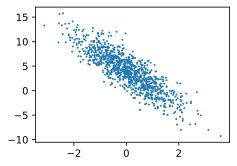

In [6]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_exaples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_exaples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0],'\nlabel:',labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)   

def data_iter(batch_size,features,labels):
    num_examples = len(features)  # 样本个数
    indices = list(range(num_examples)) # 样本索引
    # 这些样本是随即读取的，没有特定的顺序
    random.shuffle(indices) # 把索引随即打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)]) # 当i+batch_size超出时，取num_examples         
        yield features[batch_indices], labels[batch_indices] # 获得随即顺序的特征，及对应的标签
        
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 取一个批次后，就break跳出了
    break

# 定义初始化模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

# 定义模型
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

# 定义损失函数
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2/2 # 将y统一成与y_hat一样同尺寸   

# 定义优化算法
def sgd(params,lr,batch_size):
    """小批量随即梯度下降"""
    with torch.no_grad(): # 不要产生梯度计算，减少内存消耗
        for param in params: # 每个参数进行遍历
            param -= lr * param.grad / batch_size # 每个参数进行更新，损失函数没有求均值，所以这里除以 batch_size 求了均值。由于乘法的线性关系，这里除以放在loss的除以是等价的。                          
            param.grad.zero_() # 每个参数的梯度清零

# 训练过程
lr = 0.03
num_epochs = 3
net = linreg # 这里用线性模型，这样写是很方便net赋予其他模型，只需要改一处，不需要下面所有网络模型名称都改
loss = squared_loss

# 训练过程
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # x和y的小批量损失
        # 因为l是形状是(batch_size,1)，而不是一个标量。l中所有元素被加到一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')   

# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

# 7. 线性回归（使用框架）

In [7]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn    
    
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w,true_b,1000) # 库函数生成人工数据集    

# 调用框架现有的API来读取数据
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # dataset相当于Pytorch的Dataset。一个星号*，表示对list解开入参。      
    return data.DataLoader(dataset,batch_size,shuffle=is_train) # 返回的是从dataset中随机挑选出batch_size个样本出来     

batch_size = 10
data_iter = load_array((features,labels),batch_size) # 返回的数据的迭代器
print(next(iter(data_iter))) # iter(data_iter) 是一个迭代器对象，next是取迭代器里面的元素  

# 使用框架的预定义好的层
# nn是神经网络的缩写
net = nn.Sequential(nn.Linear(2,1))

# 初始化模型参数
net[0].weight.data.normal_(0,0.01) # 使用正态分布替换掉weight变量里面的数据值
net[0].bias.data.fill_(0)  # 偏差bias变量里面的值设置为0
print(net[0])

# 计算均方误差使用的是MSELoss类，也称为平方L2范数
loss = nn.MSELoss()  #L1是算术差，L2是平方差

# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

# 训练过程代码与从零开始时所做的非常相似
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # 从DataLoader里面一次一次把所有数据拿出来
#         print("X:",X)
#         print("y:",y)
        l = loss(net(X),y) # net(X) 为计算出来的线性回归的预测值
        trainer.zero_grad() # 梯度清零
        l.backward()
        trainer.step()  # SGD优化器优化模型
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

[tensor([[ 4.0302e-01, -3.0438e-02],
        [-2.6363e-02, -1.3848e+00],
        [-9.3803e-01,  2.6146e+00],
        [ 1.0863e-01,  6.7422e-01],
        [-1.4073e+00, -7.3437e-01],
        [ 4.1662e-01,  9.1266e-02],
        [ 8.1243e-01, -4.4630e-01],
        [-1.4354e+00, -2.9520e-01],
        [ 1.1644e-03, -1.5696e+00],
        [-1.1745e+00,  1.7154e-02]]), tensor([[ 5.0900],
        [ 8.8735],
        [-6.5605],
        [ 2.1188],
        [ 3.8872],
        [ 4.7255],
        [ 7.3227],
        [ 2.3349],
        [ 9.5274],
        [ 1.7901]])]
Linear(in_features=2, out_features=1, bias=True)
epoch1,loss0.000225
epoch2,loss0.000105
epoch3,loss0.000105
